In [29]:
import numpy as np
from tqdm import tqdm
from scipy.linalg import eig
import matplotlib.pyplot as plt
from scipy.special import hermite
import math

In [30]:
# ## Experiment on 1d OU process

# def ou_process_1d(theta=1, mu=0, sigma=0.1, X0=0, n_steps=10000, h=1e-5):
#     X = X0
#     for _ in range(n_steps):
#         dW = np.sqrt(h) * np.random.randn()
#         X = X + theta * (mu - X) * h + sigma * dW
#     return X

# # Parameters
# m = 1000  # Increased for better resolution
# n_steps = 10000
# h = 1e-7
# lag_time = n_steps * h

# # Generate initial points
# X = np.linspace(-2, 2, m).reshape(-1, 1)
# Y = np.zeros_like(X)

# # Simulate trajectories
# for i, X0 in tqdm(enumerate(X.flatten()), total=m, desc="Simulating trajectories"):
#     Y[i] = ou_process_1d(X0=X0, n_steps=n_steps, h=h)

In [31]:
# def monomial(X, order=10):
#     X = np.atleast_2d(X)
#     n_samples, n_dims = X.shape
#     basis = [np.ones((n_samples, 1))]
#     for o in range(1, order + 1):
#         basis.append(X**o)
#     return np.hstack(basis)

def fourier_basis(X, order=10):
    X = np.atleast_2d(X)
    n_samples, n_dims = X.shape
    basis = [np.ones((n_samples, 1))]
    for o in range(1, order + 1):
        basis.append(np.sin(2 * np.pi * o * X))
        basis.append(np.cos(2 * np.pi * o * X))
    return np.hstack(basis)

def edmd(X, Y, dictionary_func):
    PsiX = dictionary_func(X)
    PsiY = dictionary_func(Y)
    K = np.linalg.pinv(PsiX.T @ PsiX) @ (PsiX.T @ PsiY)
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eig(K)
    eigenfunctions = PsiX @ eigenvectors
    return K, eigenvalues, eigenvectors, eigenfunctions

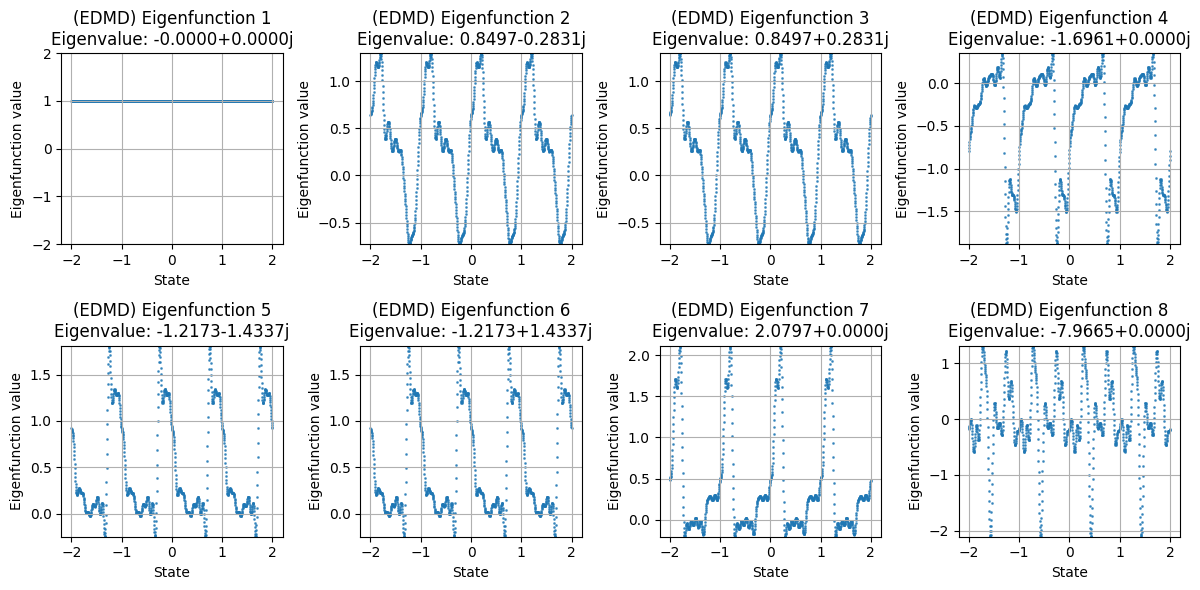

In [32]:
# Perform EDMD
K, eigenvalues, eigenvectors, eigenfunctions = edmd(X, Y, dictionary_func=fourier_basis)

# Compute continuous-time eigenvalues
continuous_eigenvalues = np.log(eigenvalues) / lag_time

# Sort eigenvalues and eigenvectors
idx = np.argsort(np.abs(continuous_eigenvalues))
sorted_eigenvalues = continuous_eigenvalues[idx]
sorted_eigenvectors = eigenvectors[:, idx]
sorted_eigenfunctions = eigenfunctions[:, idx]

# Plot eigenfunctions using scatter plots
plt.figure(figsize=(12, 6))
for i in range(8):  # Plot first 4 eigenfunctions
    eigenfunction = np.real(sorted_eigenfunctions[:, i])
    
    plt.subplot(2, 4, i+1)
    plt.scatter(X[:, 0], eigenfunction, s=1, alpha=0.7)
    plt.title(f'(EDMD) Eigenfunction {i+1}\nEigenvalue: {sorted_eigenvalues[i]:.4f}')
    plt.xlabel('State')
    plt.ylabel('Eigenfunction value')
    plt.grid(True)
    
    # Set y-axis range for each subplot
    if i == 0:  # For the first eigenfunction
        plt.ylim(-2, 2)  # Adjust this range as needed
    else:
        plt.ylim(min(eigenfunction), max(eigenfunction))

plt.tight_layout()
plt.show()

In [33]:
def true_eigenvalues(n):
    return -np.arange(n)

def true_eigenfunctions(x, n):
    eigenfunctions = []
    for i in range(n):
        herm = hermite(i)
        eigenfunction = herm(x) / np.sqrt(2**i * math.factorial(i))  # without Gaussian weight
        eigenfunctions.append(eigenfunction)
    return np.array(eigenfunctions).T

def l2_norm_difference(true, estimated):
    return np.sqrt(np.mean((true - estimated)**2))

# Calculate true eigenvalues and eigenfunctions
n_eigenfunctions = 8  # We only compare the first 4
true_evals = true_eigenvalues(n_eigenfunctions)
true_efuncs = true_eigenfunctions(X.flatten(), n_eigenfunctions)

# Remove Gaussian weight from estimated eigenfunctions
estimated_efuncs = sorted_eigenfunctions[:, :n_eigenfunctions]

# Normalize estimated eigenfunctions
for i in range(n_eigenfunctions):
    estimated_efuncs[:, i] /= np.linalg.norm(estimated_efuncs[:, i])
    if np.sum(estimated_efuncs[:, i] * true_efuncs[:, i]) < 0:
        estimated_efuncs[:, i] *= -1

# Calculate L2 norm differences
eigenvalue_errors = []
eigenfunction_errors = []

for i in range(n_eigenfunctions):
    eval_error = np.abs(true_evals[i] - np.real(sorted_eigenvalues[i]))
    efunc_error = l2_norm_difference(true_efuncs[:, i], np.real(estimated_efuncs[:, i]))
    
    eigenvalue_errors.append(eval_error)
    eigenfunction_errors.append(efunc_error)

# Print results
print("Eigenvalue absolute errors:")
for i, error in enumerate(eigenvalue_errors):
    print(f"Eigenvalue {i+1}: {error:.6f}")

print("\nEigenfunction L2 norm errors:")
for i, error in enumerate(eigenfunction_errors):
    print(f"Eigenfunction {i+1}: {error:.6f}")

# Calculate and print total errors
total_eval_error = np.sum(eigenvalue_errors)
total_efunc_error = np.sqrt(np.sum(np.array(eigenfunction_errors)**2))

print(f"\nTotal eigenvalue absolute error: {total_eval_error:.6f}")
print(f"Total eigenfunction L2 error: {total_efunc_error:.6f}")

Eigenvalue absolute errors:
Eigenvalue 1: 0.000000
Eigenvalue 2: 1.849729
Eigenvalue 3: 2.849729
Eigenvalue 4: 1.303878
Eigenvalue 5: 2.782697
Eigenvalue 6: 3.782697
Eigenvalue 7: 8.079718
Eigenvalue 8: 0.966545

Eigenfunction L2 norm errors:
Eigenfunction 1: 0.968377
Eigenfunction 2: 1.630014
Eigenfunction 3: 2.055137
Eigenfunction 4: 1.843583
Eigenfunction 5: 1.084178
Eigenfunction 6: 1.097939
Eigenfunction 7: 1.453336
Eigenfunction 8: 1.065090

Total eigenvalue absolute error: 21.614993
Total eigenfunction L2 error: 4.104217


In [34]:
# # Example with a custom dictionary function
# def custom_dictionary(X):
#     # This is just an example, you can define your own dictionary function as needed
#     return np.hstack([X, X**2, np.sin(X)])

# K_custom = edmd(X_2d, Y_2d, dictionary_func=custom_dictionary)
# print("\nKoopman operator with custom dictionary:")
# print(K_custom)

In [35]:
def jacobian(basis_func, X):
    h = 1e-8
    n_samples, n_dims = X.shape
    n_basis = basis_func(X).shape[1]
    jac = np.zeros((n_samples, n_basis, n_dims))
    
    for i in range(n_dims):
        X_plus = X.copy()
        X_plus[:, i] += h
        jac[:, :, i] = (basis_func(X_plus) - basis_func(X)) / h
    
    return jac

def hessian(basis_func, X):
    h = 1e-8
    n_samples, n_dims = X.shape
    n_basis = basis_func(X).shape[1]
    hess = np.zeros((n_samples, n_basis, n_dims, n_dims))
    
    for i in range(n_dims):
        for j in range(n_dims):
            X_plus_i = X.copy()
            X_plus_i[:, i] += h
            X_plus_j = X.copy()
            X_plus_j[:, j] += h
            X_plus_ij = X.copy()
            X_plus_ij[:, i] += h
            X_plus_ij[:, j] += h
            
            hess[:, :, i, j] = (basis_func(X_plus_ij) - basis_func(X_plus_i) - basis_func(X_plus_j) + basis_func(X)) / (h * h)
    
    return hess

def ou_drift(x, theta=1, mu=0):
    return theta * (mu - x)

def ou_diffusion(x, sigma=0.1):
    return sigma * np.ones_like(x)

def sedmd(X, dictionary_func, drift, diffusion, dt):
    PsiX = dictionary_func(X)
    jac_PsiX = jacobian(dictionary_func, X)
    hess_PsiX = hessian(dictionary_func, X)
    
    n_samples, n_dims = X.shape
    n_basis = PsiX.shape[1]
    
    L_PsiX = np.zeros_like(PsiX)
    for i in range(n_samples):
        b = drift(X[i])
        sigma = diffusion(X[i])
        
        L_PsiX[i] = np.sum(b * jac_PsiX[i], axis=1) + 0.5 * np.sum(np.sum(sigma**2 * hess_PsiX[i], axis=2), axis=1)
    
    K = np.linalg.pinv(PsiX.T @ PsiX) @ (PsiX.T @ (PsiX + dt * L_PsiX))
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eig(K)
    eigenfunctions = PsiX @ eigenvectors
    
    return K, eigenvalues, eigenvectors, eigenfunctions

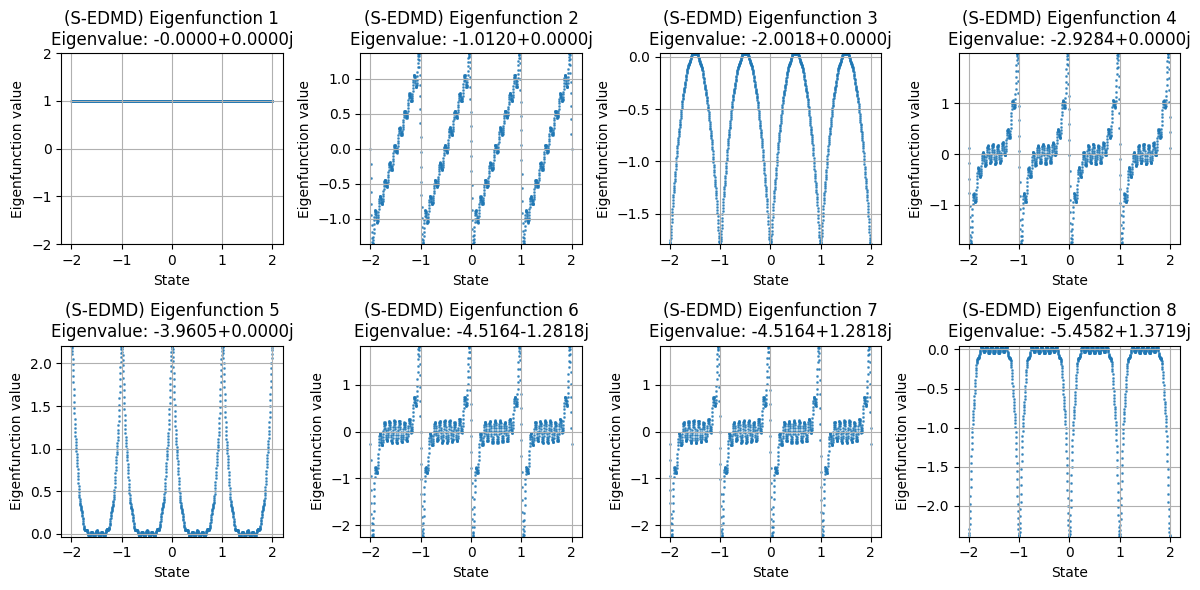

In [36]:
# Perform SEDMD
K, eigenvalues, eigenvectors, eigenfunctions = sedmd(X, fourier_basis, ou_drift, ou_diffusion, lag_time)

# Compute continuous-time eigenvalues
continuous_eigenvalues = np.log(eigenvalues) / lag_time

# Sort eigenvalues and eigenvectors
idx = np.argsort(np.abs(continuous_eigenvalues))
sorted_eigenvalues = continuous_eigenvalues[idx]
sorted_eigenvectors = eigenvectors[:, idx]
sorted_eigenfunctions = eigenfunctions[:, idx]

# Plot eigenfunctions using scatter plots
plt.figure(figsize=(12, 6))
for i in range(8):  # Plot first 4 eigenfunctions
    eigenfunction = np.real(sorted_eigenfunctions[:, i])
    
    plt.subplot(2, 4, i+1)
    plt.scatter(X[:, 0], eigenfunction, s=1, alpha=0.7)
    plt.title(f'(S-EDMD) Eigenfunction {i+1}\nEigenvalue: {sorted_eigenvalues[i]:.4f}')
    plt.xlabel('State')
    plt.ylabel('Eigenfunction value')
    plt.grid(True)
    
    # Set y-axis range for each subplot
    if i == 0:  # For the first eigenfunction
        plt.ylim(-2, 2)  # Adjust this range as needed
    else:
        plt.ylim(min(eigenfunction), max(eigenfunction))

plt.tight_layout()
plt.show()


In [37]:
# def true_eigenvalues(n):
#     return -np.arange(n)

# def true_eigenfunctions(x, n):
#     eigenfunctions = []
#     for i in range(n):
#         herm = hermite(i)
#         eigenfunction = herm(x) / np.sqrt(2**i * math.factorial(i))  # without Gaussian weight
#         eigenfunctions.append(eigenfunction)
#     return np.array(eigenfunctions).T

# def l2_norm_difference(true, estimated):
#     return np.sqrt(np.mean((true - estimated)**2))

# Calculate true eigenvalues and eigenfunctions
n_eigenfunctions = 8  # We only compare the first 4
true_evals = true_eigenvalues(n_eigenfunctions)
true_efuncs = true_eigenfunctions(X.flatten(), n_eigenfunctions)

# Remove Gaussian weight from estimated eigenfunctions
estimated_efuncs = sorted_eigenfunctions[:, :n_eigenfunctions]

# Normalize estimated eigenfunctions
for i in range(n_eigenfunctions):
    estimated_efuncs[:, i] /= np.linalg.norm(estimated_efuncs[:, i])
    if np.sum(estimated_efuncs[:, i] * true_efuncs[:, i]) < 0:
        estimated_efuncs[:, i] *= -1

# Calculate L2 norm differences
eigenvalue_errors = []
eigenfunction_errors = []

for i in range(n_eigenfunctions):
    eval_error = np.abs(true_evals[i] - np.real(sorted_eigenvalues[i]))
    efunc_error = l2_norm_difference(true_efuncs[:, i], np.real(estimated_efuncs[:, i]))
    
    eigenvalue_errors.append(eval_error)
    eigenfunction_errors.append(efunc_error)

# Print results
print("Eigenvalue absolute errors:")
for i, error in enumerate(eigenvalue_errors):
    print(f"Eigenvalue {i+1}: {error:.6f}")

print("\nEigenfunction L2 norm errors:")
for i, error in enumerate(eigenfunction_errors):
    print(f"Eigenfunction {i+1}: {error:.6f}")

# Calculate and print total errors
total_eval_error = np.sum(eigenvalue_errors)
total_efunc_error = np.sqrt(np.sum(np.array(eigenfunction_errors)**2))

print(f"\nTotal eigenvalue absolute error: {total_eval_error:.6f}")
print(f"Total eigenfunction L2 error: {total_efunc_error:.6f}")

Eigenvalue absolute errors:
Eigenvalue 1: 0.000000
Eigenvalue 2: 0.012040
Eigenvalue 3: 0.001766
Eigenvalue 4: 0.071629
Eigenvalue 5: 0.039518
Eigenvalue 6: 0.483573
Eigenvalue 7: 1.483573
Eigenvalue 8: 1.541780

Eigenfunction L2 norm errors:
Eigenfunction 1: 0.968377
Eigenfunction 2: 1.627274
Eigenfunction 3: 2.048291
Eigenfunction 4: 1.837681
Eigenfunction 5: 1.080830
Eigenfunction 6: 1.097740
Eigenfunction 7: 1.459285
Eigenfunction 8: 1.066491

Total eigenvalue absolute error: 3.633879
Total eigenfunction L2 error: 4.098596
